In [1]:
from source import Dataset
from source import tools
import awkward as ak
import glob
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#selecting features 
branches_to_train = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ",
"cscRechitClusterSize",
]

#padded_branches_to_train = []
#for col in branches_to_train:           
#    #creates padded column for each jet of each "Jets/Jets." key
#    for icol in range(10):
#        new_col_name = col+"_"+str(icol)
#        padded_branches_to_train.append(new_col_name)

#branches_to_train = [
#    "cscRechitClusterSize",
#]

print(branches_to_train)
truth_value = "cscRechitCluster_match_gLLP_e"


['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterTimeWeighted', 'cscRechitClusterTimeSpreadWeightedAll', 'cscRechitClusternXY', 'cscRechitClusternZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterXYSpread', 'cscRechitClusterRSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterDeltaRSpread', 'cscRechitClusterMajorAxis', 'cscRechitClusterMinorAxis', 'cscRechitClusterSkewX', 'cscRechitClusterSkewY', 'cscRechitClusterSkewZ', 'cscRechitClusterKurtX', 'cscRechitClusterKurtY', 'cscRechitClusterKurtZ', 'cscRechitClusterSize']


In [3]:
#dataset_signal = Dataset.Dataset("signal")
#loaded_array_signal = dataset_signal.load("/nfs/dust/cms/user/lbenato/ML_LLP/MDS_regression/datasets/test_v6.h5")

In [4]:
dataset_signal = Dataset.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/lbenato/ML_LLP/MDS_regression/datasets/test_df_v6.h5")

Opening file  /nfs/dust/cms/user/lbenato/ML_LLP/MDS_regression/datasets/test_df_v6.h5


In [5]:
df_signal.shape

(90016, 79)

In [25]:
#Consider only data with proper gen matching
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]

In [27]:
df_signal.shape

(79780, 79)

In [28]:
#splitting the data into train, test and validation
#from sklearn.model_selection import train_test_split
#
#loaded_array_signal_64 = dataset_signal.get_unstructured_numpy(loaded_array_signal)
#print(loaded_array_signal.dtype)
#print(loaded_array_signal_64.dtype)
#    
#loaded_array_signal_df = loaded_array_signal_64
#
#print(loaded_array_signal_64)

In [29]:
# Splitting the loaded_array_signal data
#train_data, testval_data = train_test_split(loaded_array_signal_df, train_size=0.6)
train_data, testval_data = train_test_split(df_signal, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

# assigning labels
train_labels = np.array(train_data[truth_value])#([1.]*len(train_data))
test_labels = np.array(test_data[truth_value])#([1.]*len(test_data))
val_labels = np.array(val_data[truth_value])#([1.]*len(val_data))

train_data = train_data[branches_to_train]
test_data = test_data[branches_to_train]
val_data = val_data[branches_to_train]

# check the shape
print("First example:")
print("signal training features", train_data.shape)
print("signal training labels", train_labels.shape)
print("signal test features", test_data.shape)
print("signal test labels", test_labels.shape)
print("signal val features", val_data.shape)
print("signal val labels", val_labels.shape)

print(train_labels)
print(train_data[branches_to_train])

#print(type(train_data), type(train_labels))
n_features = train_data.shape[1]

First example:
signal training features (47868, 25)
signal training labels (47868,)
signal test features (15956, 25)
signal test labels (15956,)
signal val features (15956, 25)
signal val labels (15956,)
[ 47.68254089  98.56023407 103.9028244  ... 116.4883194  230.63546753
  99.98383331]
       cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
23018        -311.808868         244.498947         848.761230   
44895         399.104065        -513.735535         693.840332   
62249         387.325439        -325.646210        -811.453674   
40637         451.939575         277.207031         862.512329   
22085         104.622169         -71.902878         609.470215   
...                  ...                ...                ...   
13927        -333.599182        -416.067017        -693.437683   
74441         277.425964        -165.012939         687.181396   
803            26.589790        -469.242249        

In [30]:
# concatenate data
#train_data = np.concatenate([bkg_train_data,sig_train_data], axis=0)
#test_data = np.concatenate([bkg_test_data, sig_test_data], axis=0)
#val_data = np.concatenate([bkg_val_data, sig_val_data], axis=0)

#train_labels = np.concatenate([bkg_train_labels, sig_train_labels], axis=0)
#test_labels = np.concatenate([bkg_test_labels, sig_test_labels], axis=0)
#val_labels = np.concatenate([bkg_val_labels, sig_val_labels], axis=0)

print("training features", train_data.shape)
print("training labels", train_labels.shape)
print("test features", test_data.shape)
print("test labels", test_labels.shape)
print("val features", val_data.shape)
print("val labels", val_labels.shape)
print(val_labels)

training features (47868, 25)
training labels (47868,)
test features (15956, 25)
test labels (15956,)
val features (15956, 25)
val labels (15956,)
[126.64868164 187.53904724 103.64417267 ... 258.44216919 109.36463165
 321.24499512]


In [31]:
 # shuffle

X_train, Y_train = sklearn.utils.shuffle(train_data, train_labels, random_state=0) # change to random_state=None for full randomness
X_test, Y_test = sklearn.utils.shuffle(test_data, test_labels, random_state=0) # change to random_state=None for full randomness
X_val, Y_val = sklearn.utils.shuffle(val_data, val_labels, random_state=0) # change to random_state=None for full randomness

print("shuffled training features", X_train)
print("shuffled training features", X_train.shape)
print("shuffled training labels", Y_train)
print("shuffled training labels", Y_train.shape)

shuffled training features        cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
30288        -557.086975        -111.016998         710.512634   
22690        -140.125977         -16.270750         643.322937   
18841        -418.065277         127.958069         711.587036   
24267        -320.429993        -338.931854        -844.561401   
2079         -370.174072         -35.838058         700.081970   
...                  ...                ...                ...   
9121          165.266510        -164.984940       -1025.306152   
29953         447.729492         -86.829102         688.562012   
24936         270.138977         587.870422         693.937012   
81450         -54.067993         329.205872         951.753662   
46059        -521.813171        -207.220688         695.213318   

       cscRechitClusterTimeWeighted  cscRechitClusterTimeSpreadWeightedAll  \
entry                               

In [32]:
#defining the model and metrics
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=200, seed=None)
    initializer = tf.keras.initializers.Constant(value=100)

    
    model = keras.Sequential([
        #keras.layers.Dense(5, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        #keras.layers.Dropout(0.5),
        #keras.layers.Dense(1, activation='relu', bias_initializer=output_bias, kernel_initializer=initializer)
        #Attempt:
        keras.layers.Dense(50, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        #keras.layers.Dense(1, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(1)

    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #optimizer=keras.optimizers.SGD(learning_rate=0.01),
        #loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(name='MSE'),
        metrics=metrics
    )
    
    return model

# TODO: Find best way to init weights

In [33]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #val_prec
    verbose=1,
    patience=10,
    mode='min',#max
    restore_best_weights=True)

In [34]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                1300      
                                                                 
 dense_11 (Dense)            (None, 30)                1530      
                                                                 
 dense_12 (Dense)            (None, 20)                620       
                                                                 
 dense_13 (Dense)            (None, 5)                 105       
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


In [35]:
output = model.predict(X_train)
print(output)
print(Y_train)

1496/1496 [==============================] - 2s 1ms/step
[[-29607.75 ]
 [-38087.758]
 [-12324.1  ]
 ...
 [-36879.047]
 [-42373.68 ]
 [-25966.035]]
[422.18743896 326.69186401  87.08818817 ...  64.66755676 173.08444214
 100.1175766 ]


In [36]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1287571584.0000


In [37]:
model = make_model()
history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=EPOCHS, #EPOCHS
    callbacks=[early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
479/479 [==============================] - 6s 7ms/step - loss: 6056045.0000 - cross entropy: 541.9663 - Brier score: 646811392.0000 - tp: 36791.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 58945.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.3843 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 5462732.0000 - val_cross entropy: 1518.1365 - val_Brier score: 5462732.0000 - val_tp: 3157.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 12799.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.1979 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/100
479/479 [==============================] - 3s 5ms/step - loss: 77767.2422 - cross entropy: -2209.2263 - Brier score: 77767.2422 - tp: 46269.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1599.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9666 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 11759.0518 - val_cross entropy: -2382.1233 - val_Brier score: 11759.0518 - val_tp: 15956.0000 - val_fp

479/479 [==============================] - 2s 5ms/step - loss: 58176.1914 - cross entropy: -1981.7156 - Brier score: 58176.1914 - tp: 44131.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 3737.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9219 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 25621.7402 - val_cross entropy: -781.3483 - val_Brier score: 25621.7402 - val_tp: 10921.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 5035.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6844 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 16/100
479/479 [==============================] - 2s 5ms/step - loss: 75003.5391 - cross entropy: -1582.4282 - Brier score: 75003.5391 - tp: 40188.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 7680.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.8396 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 65274.5039 - val_cross entropy: -2382.1233 - val_Brier score: 65274.5039 - val_tp: 15956.0000 - val_fp: 0.0000e+00 - val_t

In [38]:
pred_output = model.predict(X_train[:10])
print(pred_output)
print(Y_train[:10])

results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss on training: {:0.4f}".format(results[0]))

results_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)
print("Loss on validation: {:0.4f}".format(results_val[0]))

1/1 [==============================] - 0s 76ms/step
[[126.894104]
 [129.09723 ]
 [ 39.771053]
 [148.71037 ]
 [ 97.32379 ]
 [ 69.456604]
 [231.44879 ]
 [ 68.57379 ]
 [148.71037 ]
 [ 69.52301 ]]
[422.18743896 326.69186401  87.08818817 108.66213226 178.54800415
 184.39175415 105.66104889 194.80322266 164.13456726 123.49138641]
Loss on training: 8536.4639
Loss on validation: 8697.6279


In [39]:
# Plots of loss vs epoch 
# Plot of ROC

train_predictions = model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_data, batch_size=BATCH_SIZE)
print(len(test_data),len(test_predictions))

8/8 [==============================] - 0s 3ms/step
15956 15956


In [40]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history.keys())

[6056045.0, 77767.2421875, 450603.25, 18461.2890625, 96252.0, 556408.125, 117229.3125, 1009056.3125, 13743.884765625, 70758.4765625, 88580.90625, 333627.625, 215758.8125, 235692.46875, 58176.19140625, 75003.5390625, 80732.8671875]
[5462732.0, 11759.0517578125, 317643.53125, 11094.84765625, 172555.09375, 8725.576171875, 8697.626953125, 13532.0419921875, 11963.1337890625, 679744.5, 44190.33203125, 66724.3359375, 22351.796875, 5290947.0, 25621.740234375, 65274.50390625, 24916.828125]
dict_keys(['loss', 'cross entropy', 'Brier score', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_cross entropy', 'val_Brier score', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


In [41]:
#AUC
#sklearn.metrics.roc_auc_score(test_labels, test_predictions_baseline)

In [42]:
#sklearn.metrics.roc_auc_score(train_labels, train_predictions_baseline)

In [43]:
from source.tools import tools
obj = tools()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    metrics = ['loss', 'Brier score', 'precision', 'recall']
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([1, plt.ylim()[1]])
            plt.yscale("log")
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'Brier score':
            plt.ylim([0.1,12527118336])
            plt.yscale("log")
        else:
            plt.ylim([0,1.1])

    plt.legend()

[646811392.0, 77767.2421875, 450603.25, 18461.2890625, 96252.0, 556408.125, 117229.3125, 1009056.3125, 13743.884765625, 70758.4765625, 88580.90625, 333627.625, 215758.8125, 235692.46875, 58176.19140625, 75003.5390625, 80732.8671875]


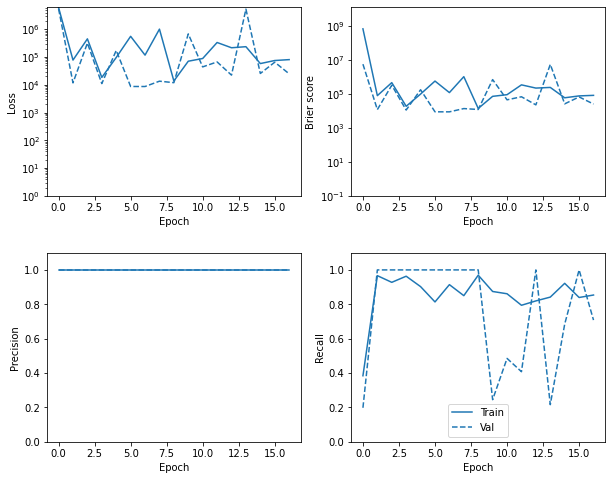

In [44]:
plot_metrics(history)
print(history.history['Brier score'])

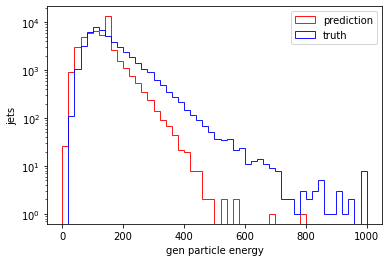

[[ 72.28473 ]
 [ 32.936092]
 [101.959625]
 ...
 [105.825745]
 [139.47809 ]
 [128.65485 ]]


In [45]:
obj = tools()
obj.plotHist(train_predictions,train_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

#obj.plotHist(test_predictions_signal, test_predictions_background, bins = 50, interval=[0,1], logy=True, logx=False, labels=["signal test", "background test"],
#             xlabel= 'DNN output', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

print(train_predictions)